## 1. Descrição do experimento
Neste documento, iremos abordar conceitos avançados da regressão linear simples (univariada). Com a finalidade de não só contextualizar, mas simplificar e motivar o entendimento de alguns conceitos desse modelo, irei me apoiar num exemplo mecânico simples: determinação da constante elástica de uma mola.

Nesse experimento, mediremos a deformação causada devido a presença de blocos de diferentes massas na extremidade de uma mola de constante elástica $k$ (a determinar). Para isso, criarei um conjunto de dados **sintético** que ilustra bem como esse experimento se dá na vida real. Em seguida, irei desconsiderar o modelo (linear) que usei para sintetizar esses dados e, usando regressão linear, vamos estimar o coeficiente $k$.

### Modelo Físico (Lei de Hooke)

* Lei de Hooke
$$
F=kx
$$

* 2a Lei de Newton<br>
Um bloco cujas únicas forças atuantes são peso $(m\vec{g})$ e força elástica $(k\vec{x})$ estará em equilíbrio se:

$$
\sum{\vec{F}} = 0 \qquad \therefore \qquad mg = kx
$$

* $m$: massa do bloco [kg]
* $g$: aceleração da gravidade [m/s]
* $k$: constante elástica da mola [N/m]
* $x$: deformação sofrida pela mola [m]

A igualdade encontrada acima pode ser reescrita de modo a evidenciar que a deformação $x$ é uma função da massa $m$

$$
x \equiv x(m) \qquad \therefore \qquad x(m) = \frac{g}{k}m
$$

Não iremos considerar as incertezas quanto ao uso da constante $g$ nem das massas utilizadas. Sendo assim, todo o caráter aleatório do problema é motivado por fatores externos (como erros na leitura da deformação). A esses fatores externos que não conseguimos controlar nem explicar, irei adicioná-los ao modelo acima uma parcela de erro com média zero e variância constante. Assim:

$$
x(m) = \frac{g}{k}m + \varepsilon
$$
Onde:
* $\mathbb{E}(\varepsilon)=0$
* $\text{Var}(\varepsilon)=\text{cte}$

## 2. Gerando os dados
Para simular o experimento, irei considerar:
* Constante elástica (real) da mola igual a 5N/m
* Aceleração da gravidade igual a 9,81m/s<sup>2</sup>
* Assumir que o erro segue uma distribuição normal de média 0 e desvio 0.02 metros

In [1]:
# Importando as bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
# Constantes e parâmetros reais do modelo populacional
k  = 5
g  = 9.81
massas = (np.arange(1,41)*5)/1e3

# Parcela de erro
np.random.seed(42)
erros = np.random.normal(0, 0.02, size=massas.shape)
deformacoes = massas * g / k + erros

# Dataframe com os dados sintéticos
populacao = pd.DataFrame({"Mass (kg)": massas, "Deformation (m)": deformacoes})

In [3]:
populacao.head()

,Mass (kg),Deformation (m)
0,0.005,0.019744
1,0.010,0.016855
2,0.015,0.042384
3,0.020,0.069701
4,0.025,0.044367


## 3. Definindo as amostras
Considaremos 4 amostras de diferentes tamanhos da população. Cada amostra representa um subconjunto dos dados experimentais

In [4]:
tam_amostras = [10, 22, 8, 31]
amostras = [populacao.sample(n=num_obs, random_state=42 + i, replace=False) for i, num_obs in enumerate(tam_amostras)]

## 4. Visualizando as amostras
Cada amostra é visualizada no gráfico de dispersão abaixo, evidenciando a variabilidade devido a parcela de erro

In [5]:
cores = plt.cm.plasma(np.linspace(0.2, 0.8, len(tam_amostras)))

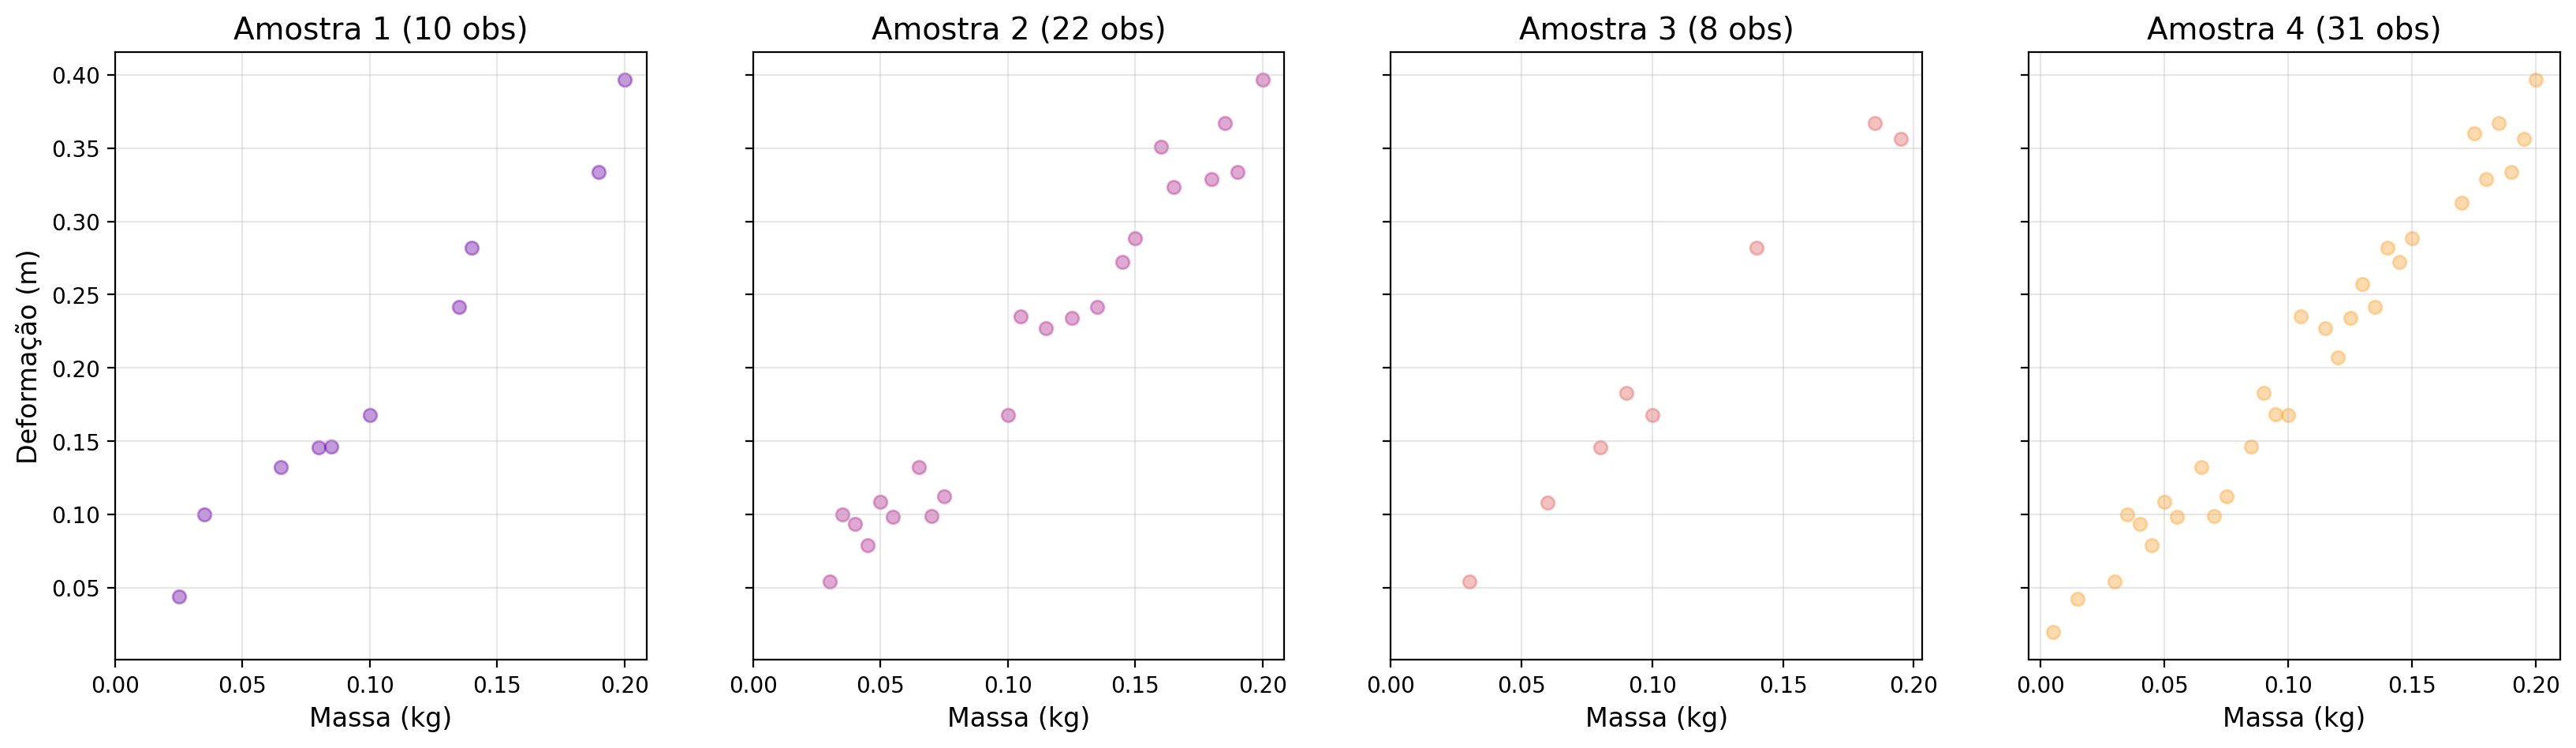

In [6]:
fig, axes = plt.subplots(1, len(tam_amostras), figsize=(20, 5), sharey=True)

for i, (amostra, ax) in enumerate(zip(amostras, axes)):
    ax.scatter(amostra["Mass (kg)"], amostra["Deformation (m)"], label=f"Amostra {i+1} ({len(amostra)} obs)", alpha=0.4, color=cores[i])
    ax.set_title(f"Amostra {i+1} ({len(amostra)} obs)", fontsize=14)
    ax.set_xlabel("Massa (kg)", fontsize=12)
    ax.grid(True,alpha=0.3)
    ax.set_xticks(np.arange(0,250,50)/1e3)
        
axes[0].set_ylabel("Deformação (m)", fontsize=12)
plt.show()

> As observações das amostras acima foram retiradas **da mesma população**. Contudo, veremos a seguir que prosseguindo com a obtenção da reta de regressão para cada amostra, teremos como resultado retas diferentes. Mais que isso, as retas obtidas **não serão iguais** a real reta (e.g., modelo populacionou) que originou cada uma das amostras

## 5 Regressão Linear
De posse do gráfico visto anteriormente, podemos **assumir** que a relação entre as quantidades é linear - ainda que somente para o intervalo de valores analisado. Ao fazer isso, o problema agora consiste em **estimar** os coeficientes/parâmetros da reta

$$
\hat{y}_i = \hat{\beta_0} + \hat{\beta_1} x_i
$$

> **Nota**: Quando consideramos que a relação entre as quantidades acima é linear, estamos assumindo que a relação **verdadeira** da população é linear. No entanto, como não temos dados da população, mas sim de uma amostra, o que nos resta é **estimar** os coeficientes da reta referentes associados a amostra considerada. Os valores $\hat{\beta_0}$ e $\hat{\beta_1}$ são estimadores, pois serão calculados com base somente no conjunto de dados fornecidos. Caso uma outra amostra contendo outras observações, realizadas em outro momento, sob outras condições etc, o valor dos coeficientes seria diferente.

In [7]:
# Importando classes e pacotes
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

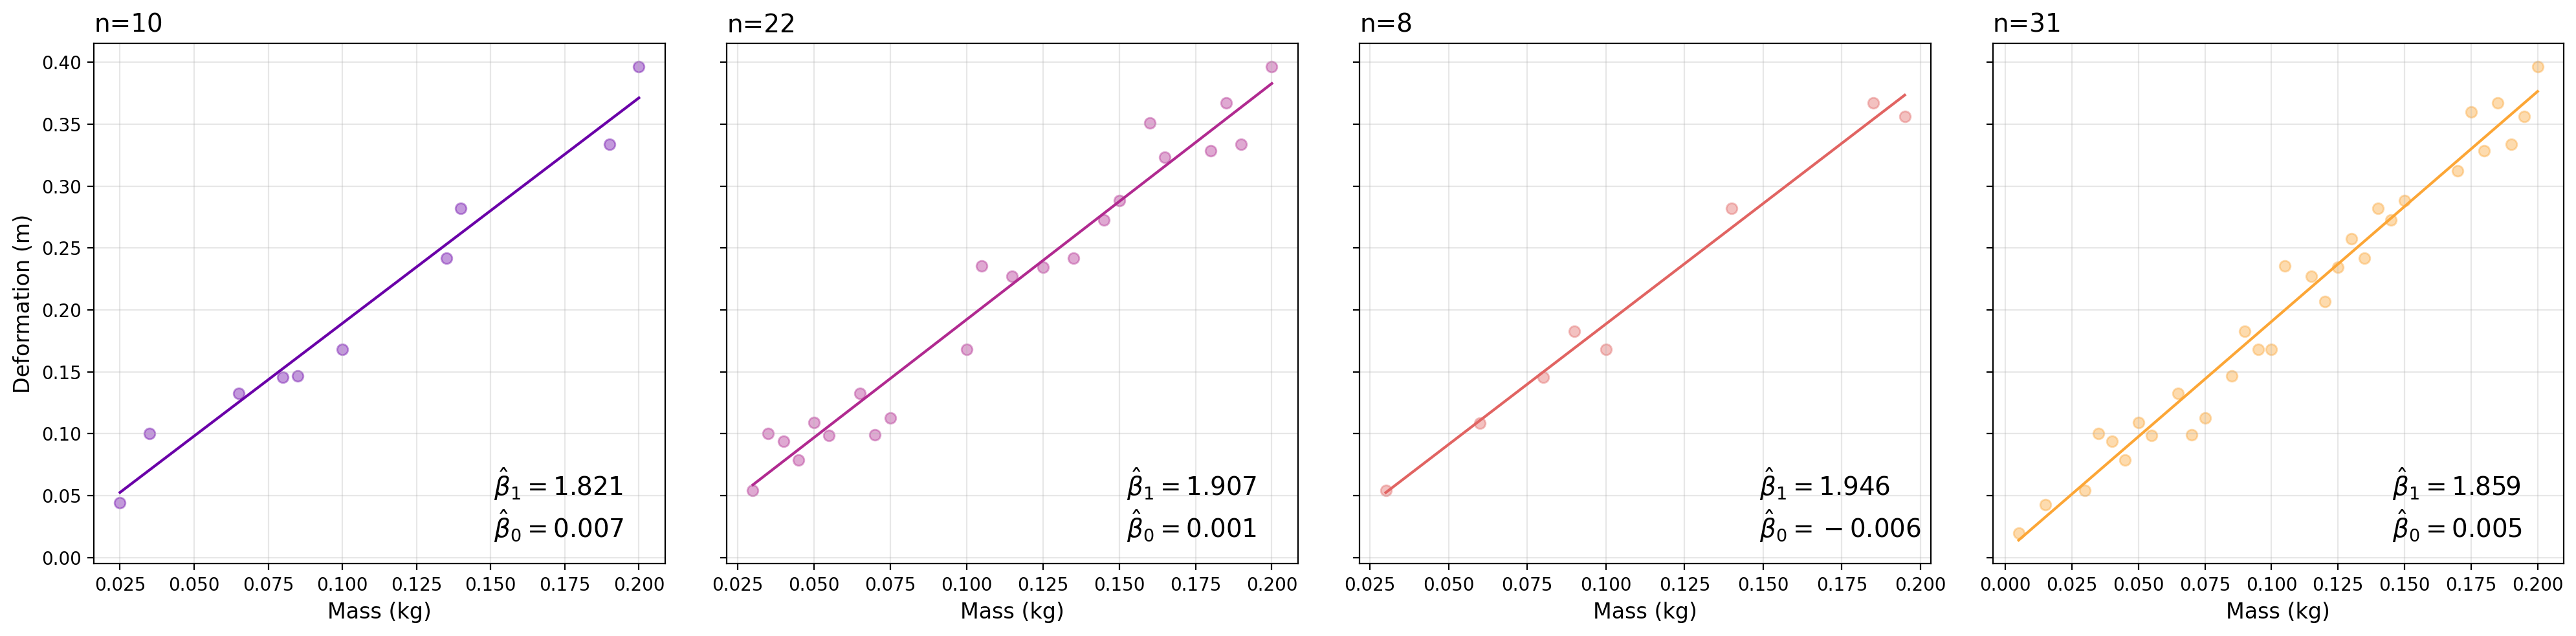

In [9]:
fig, axes = plt.subplots(1, len(tam_amostras), figsize=(20, 5), sharey=True)

for i, (amostra, ax) in enumerate(zip(amostras, axes)):
    
    # Define os valores de X e y para regressão
    X = amostra[["Mass (kg)"]].values
    y = amostra["Deformation (m)"].values

    # Usa o statsmodels para calcular estatísticas detalhadas do modelo
    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()

    # Estima reta de regressão
    X_pred = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    X_pred_with_const = sm.add_constant(X_pred)
    y_pred = model.predict(X_pred_with_const)

    # Exibe as observações por amostra e reta de regressão
    ax.scatter(X, y, label=f"Amostra {i+1} ({len(amostra)} obs)", alpha=0.4, color=cores[i])
    ax.plot(X_pred, y_pred, label="Reta regressão",color=cores[i])

    # Insere caixa de texto com os coeficientes estimados
    coef_text = (rf"$\hat\beta_1={model.params[1]:.3f}$" + "\n" + rf"$\hat\beta_0={model.params[0]:.3f}$")
    ax.text(0.70, 0.05, coef_text, transform=ax.transAxes, fontsize=14)

    ax.set_title(f"n={len(amostra)}", loc='left', fontsize=14)
    ax.set_xlabel("Mass (kg)", fontsize=12)
    ax.grid(True,alpha=0.3)

axes[0].set_ylabel("Deformation (m)", fontsize=12)
plt.tight_layout()
plt.show()

Isto é, as retas de regressão obtidas foram:

* Amostra 1, $n=10$:
    * $\hat{x} = 0.007 + 1.821\cdot m$
* Amostra 2, $n=22$:
    * $\hat{x} = 0.001 + 1.07\cdot m$
* Amostra 3, $n=8$:
    * $\hat{x} = -0.006 + 1.946\cdot m$
* Amostra 4, $n=31$:
    * $\hat{x} = 0.005 + 1.859\cdot m$

Veja que embora próximos, os valores estimados para $\hat\beta_0$ e $\hat\beta_1$ são diferentes para cada amostra. Isso será explicado mais detalhadamente abaixo ao fazermos uma breve digressão sobre estimadores de parâmetros populacionais

### Estimadores

O problema de se encontrar os estimadores $\hat\beta_0$ e $\hat\beta_1$ acima é análogo ao problema de encontrar a média populacional de uma variável aleatória. Após encontrar os valores de $\hat\beta_0$ e $\hat\beta_1$ usando o método dos mínimos quadrados, obtemos:

$$
\hat\beta_0 = \bar{y} - \hat{\beta_1} \bar{x}
$$

$$
\hat\beta_1 = \frac{\sum{(x_i - \bar{x})(y_i - \bar{y})}}{\sum{(x_i - \bar{x})^2}}
$$

Note que $y_i = \beta_0 + \beta_1 x_i + \varepsilon_i$ faz com que $y_i$ seja uma variável aleatória (devido a presença do erro $\varepsilon$). Sendo assim, $\hat{\beta_1}$ é uma variável aleatória e, consequentemente, $\hat{\beta_0}$ também será.

Os estimadores $\hat{\beta_0}$ e $\hat{\beta_1}$ serão considerados **não enviesados** se seu valor esperado for igual a média. Isto é, se calculando a média de todos os estimadores possíveis obtivermos o valor real do parâmetro populacional. Fazendo as contas, confirma-se que:

* $\mathbb{E}(\hat{\beta_0}) = \beta_0$
* $\mathbb{E}(\hat{\beta_1}) = \beta_1$

Em outras palavras, se considerássemos uma quantidade absurdamente grande de amostras, esperamos que, ao fazer a média de todos os coeficientes estimados, obteremos o real.

## 6. Comparando e avaliando as regressões
Agora vamos comparar as retas de regressao estimadas para cada amostra - note a diferença entre as inclinações e o ponto de interseção com o eixo vertical (intercepto)

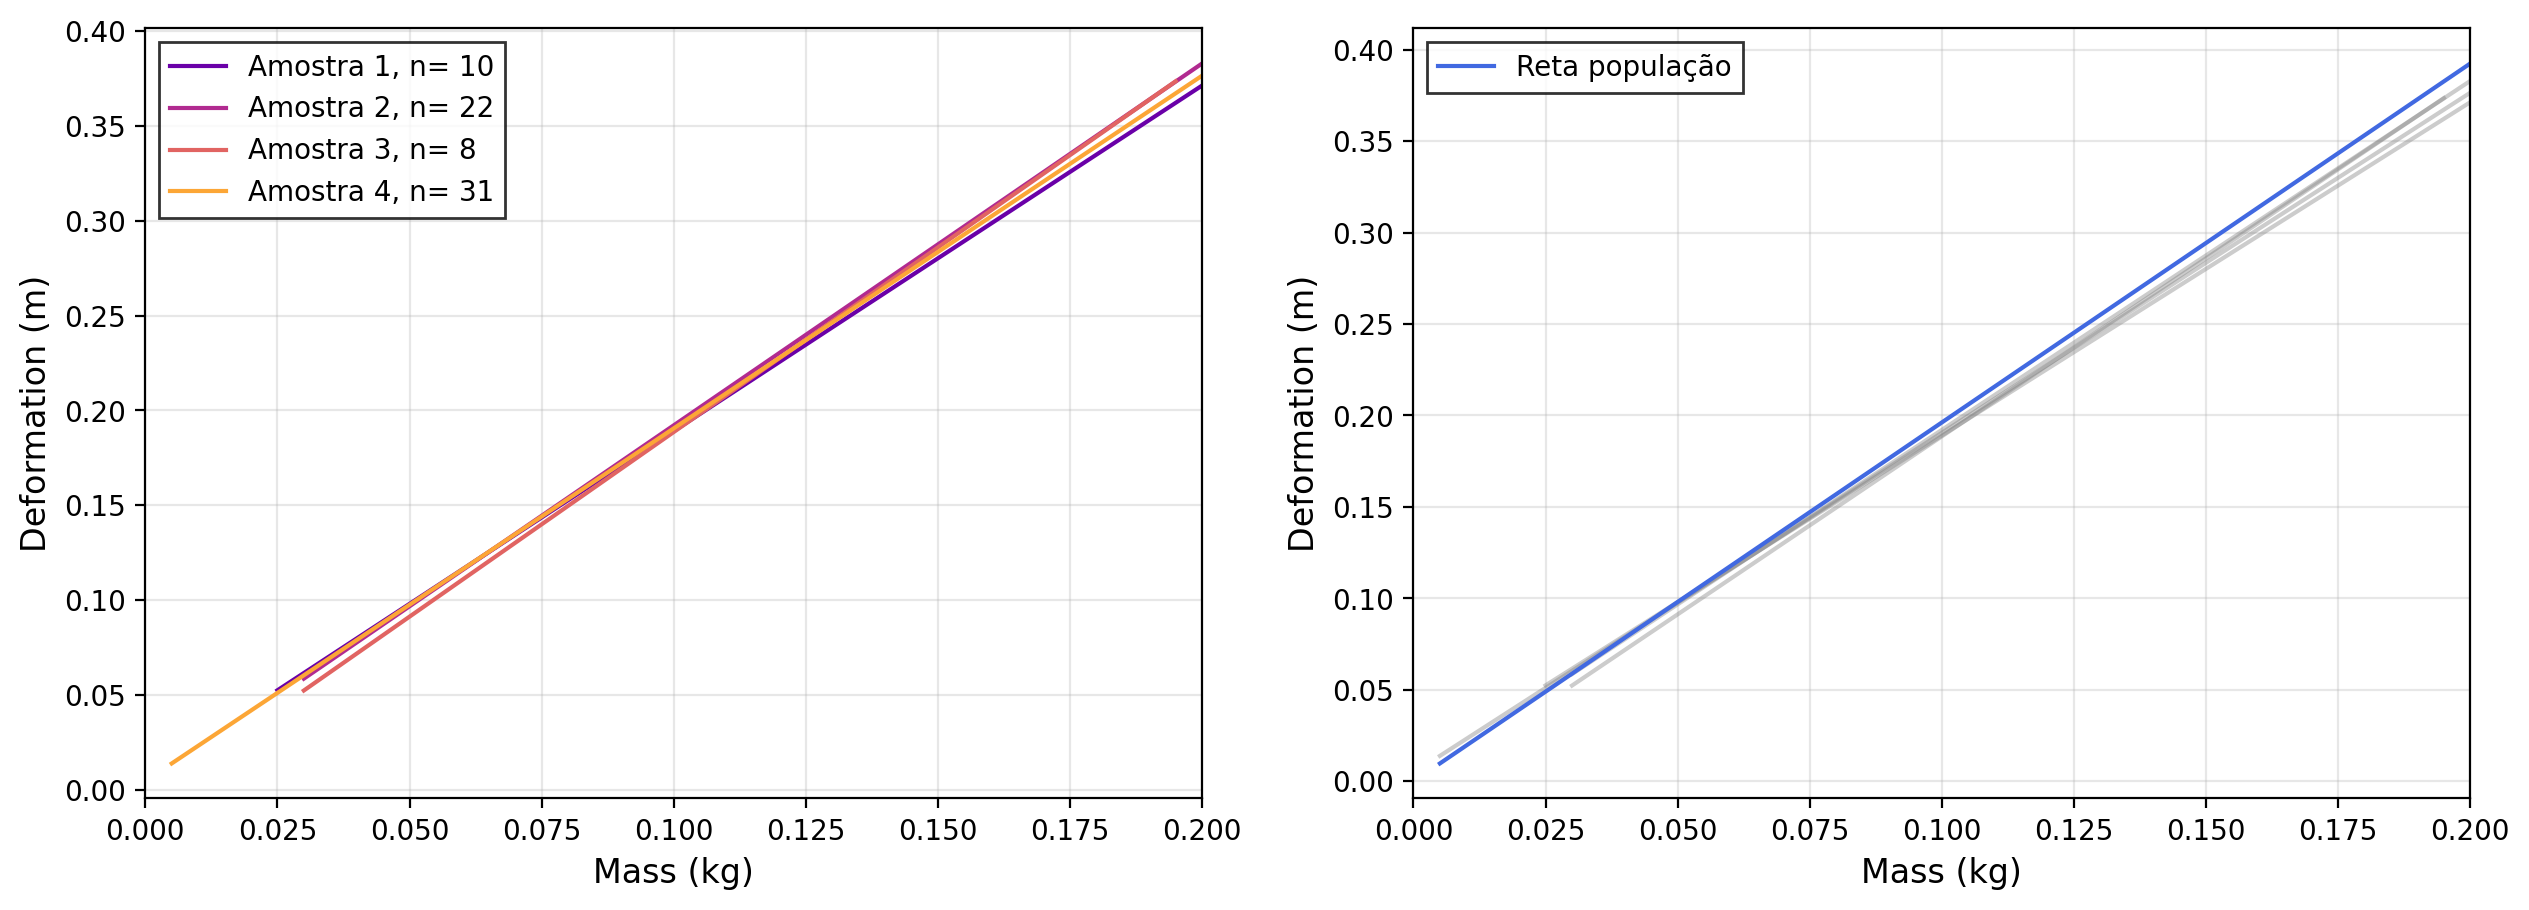

In [10]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

for i, (amostra, cor) in enumerate(zip(amostras, cores)):
    X = amostra[["Mass (kg)"]].values
    y = amostra["Deformation (m)"].values

    # Perform regression using statsmodels
    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()

    # Generate regression line
    X_pred = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    X_pred_with_const = sm.add_constant(X_pred)
    y_pred = model.predict(X_pred_with_const)

    # Plot regression line
    axs[0].plot(X_pred, y_pred, label=f"Amostra {i+1}, n= {len(amostra)}", color=cor)
    axs[1].plot(X_pred, y_pred, color='gray',alpha=0.4)

axs[1].plot(populacao['Mass (kg)'], populacao['Mass (kg)']*g/k, color='royalblue', label='Reta população')

for ax in axs:
    ax.set_xlabel("Mass (kg)", fontsize=12)
    ax.set_ylabel("Deformation (m)", fontsize=12)
    ax.set_xlim(0,0.2)
    ax.legend(fancybox=False, edgecolor='k')
    ax.grid(True,alpha=0.3)
plt.show()

Note como as retas de cada regressão são diferentes entre si e também diferentes da reta populacional. Contudo, ao calcularmos os estimadores para um número muito grande de amostras, na média, esses estimadores serão iguais ao valor real

In [13]:
# Consolida as estatísticas das amostras num dataframe
estatisticas_estimadores = []

for i, amostra in enumerate(amostras):
    X = amostra[["Mass (kg)"]].values
    y = amostra["Deformation (m)"].values

    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()

    # Extrai as estatísticas e adiciona a lista
    for coef_name, coef_value, t_stat, p_val, std_err in zip(
        [r"$\hat{\beta}_0$", r"$\hat{\beta}_1$"], model.params, model.tvalues, model.pvalues, model.bse
    ):
        estatisticas_estimadores.append({
            "Amostra": f"Amostra {i+1}",
            "Coeficiente": coef_name,
            "Estimativa": coef_value,
            "t-statistic": t_stat,
            "p-value": p_val,
            "SE": std_err
        })

# Cria o dataframe
tabela_estatisticas_estimadores = pd.DataFrame(estatisticas_estimadores)

In [14]:
tabela_estatisticas_estimadores

,Amostra,Coeficiente,Estimativa,t-statistic,p-value,SE
0,Amostra 1,$\hat{\beta}_0$,0.006967,0.518162,6.183669e-01,0.013446
1,Amostra 1,$\hat{\beta}_1$,1.821295,16.232730,2.085994e-07,0.112199
2,Amostra 2,$\hat{\beta}_0$,0.001408,0.135331,8.937027e-01,0.010405
3,Amostra 2,$\hat{\beta}_1$,1.907241,22.558356,1.072334e-15,0.084547
4,Amostra 3,$\hat{\beta}_0$,-0.006000,-0.502071,6.335067e-01,0.011950
5,Amostra 3,$\hat{\beta}_1$,1.946003,20.014217,1.009996e-06,0.097231
6,Amostra 4,$\hat{\beta}_0$,0.004657,0.655299,5.174402e-01,0.007107
7,Amostra 4,$\hat{\beta}_1$,1.858846,31.633576,4.935885e-24,0.058762


O valor que queremos estimar é a constante elástica da mola, $k$. De acordo com o modelo, $k$ é dado por:
$$
\beta_1 = g/k \qquad \therefore \qquad \hat{k} = \frac{g}{\hat\beta_1}
$$

Iterando pelas linhas da tabela acima e computando o valor da constante a partir do valor estimado para a inclinação, obtemos

In [28]:
for index, row in tabela_estatisticas_estimadores.iterrows():
    if index % 2 == 1:
        nome_amostra = tabela_estatisticas_estimadores.loc[index, 'Amostra']
        print(f"{nome_amostra}: {round(g/tabela_estatisticas_estimadores.loc[index, 'Estimativa'],3)}")

Amostra 1: 5.386
Amostra 2: 5.144
Amostra 3: 5.041
Amostra 4: 5.277


## 7. Métricas de desempenho
Agora vamos avaliar a qualidade do ajuste do modelo usando R2 e RSE

In [29]:
from sklearn.metrics import r2_score, mean_squared_error

In [35]:
for i, amostra in enumerate(amostras):
    X = amostra[["Mass (kg)"]].values
    y = amostra["Deformation (m)"].values

    # Perform regression using statsmodels
    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()

    # Generate regression line
    X_pred = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    X_pred_with_const = sm.add_constant(X_pred)
    y_pred = model.predict(X_pred_with_const)

    # Predizer os valores usando as mesmas entradas de y
    y_pred = model.predict(X_with_const)
    
    # Cálculo das métricas
    r2 = r2_score(y, y_pred)  # R^2
    mse = mean_squared_error(y, y_pred)  # MSE
    rse = np.sqrt(mse * len(y) / (len(y) - 2))  # RSE, ajustando para o número de parâmetros
    print(f"Amostra {i+1}")
    print(f"R2: {r2:.3f}")
    print(f"MSE: {mse:.3f}")
    print(f"RSE: {rse:.3f}\n")

Amostra 1
R2: 0.971
MSE: 0.000
RSE: 0.020

Amostra 2
R2: 0.962
MSE: 0.000
RSE: 0.022

Amostra 3
R2: 0.985
MSE: 0.000
RSE: 0.015

Amostra 4
R2: 0.972
MSE: 0.000
RSE: 0.018

